In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from data_access.get_stock_price_yahoo import get_hk_stock_price 
from matplotlib import style
style.use('seaborn')

In [2]:
df = pd.read_csv('data/aastock/vader_HSI_score_16:00_16:00.csv')
df['ret'] = df.HSI_close.shift(-1)/df.HSI_close - 1
# df['dir'] = df.ret.apply(lambda x: 1 if x>0 else -1 if x<0 else 0)
df.dropna(inplace=True)
df.drop(columns=['HSI_close','HSI_open','HSI_high','HSI_low','HSI_volume', 'number_of_news'], inplace=True)
# set start date
df = df[df['date_time'] > '2017']
df.head()

date_time  score_title  score_content  weighted_number_of_news       ret
490  2017-01-03     0.036369      -0.079684                 0.256313 -0.000719
491  2017-01-04     0.001115       0.004709                 0.020642  0.014557
492  2017-01-05     0.117174       0.088493                 0.461415  0.002063
493  2017-01-06     0.045130       0.090721                 0.163702  0.002474
494  2017-01-09     0.003677       0.018253                 0.036354  0.008252

In [18]:
# Normalization
ma = df['score_content'].rolling(window=10).mean()
sd = df['score_content'].rolling(window=10).std()
df['score_content'] = (df['score_content'] - ma)/sd
df.dropna(inplace=True)


In [3]:
def compute_metrics(signal, HSI_ret):
    if not signal.any():
        return {'mdd': 0,
        'annual_ret' : 0,
        'annual_vol' : 0,
        'win_rate' : 0,
        'sharpe': 0,
        'sortino': 0,
        'calmar': 0}
    start_date = HSI_ret.index[0]
    pnl = signal * HSI_ret
    cumret = pnl.cumsum() - 1
    drawdown = cumret - cumret.cummax()
    mdd = drawdown.min()
    win_rate = len(pnl[pnl>0])/ (len(pnl[pnl>0])+ len(pnl[pnl<0]))
    annual_ret = pnl.mean() * 252
    annual_vol = pnl.std() * np.sqrt(252)
    sharpe = annual_ret/annual_vol
    sortino = pnl.mean()/ pnl[pnl<0].std() * np.sqrt(252)
    calmar = annual_ret / abs(mdd)
    metrics_dict = {'mdd': mdd,
                    'annual_ret' : annual_ret,
                    'annual_vol' : annual_vol,
                    'win_rate' : win_rate,
                    'sharpe': sharpe,
                    'sortino': sortino,
                    'calmar': calmar}
    return metrics_dict

In [4]:
heatmap_v = {'sharpe': (-1.5, 2),
             'win_rate': (0.35,0.65),
             'annual_ret': (-0.2,0.2),
             'mdd': (-0.4,0.0),
             'sortino': (-0.8,1.8),
             'calmar': (-0.5,2)
            }

def strategy_heatmap(strategy, params_dict = {}, metrics = ['annual_ret','mdd', 'sharpe', 'sortino', 'calmar','win_rate'], save_name=None):
    param_1, param_2 = params_dict.items()
    param_1_name, param_1_list = param_1
    param_2_name, param_2_list = param_2
    metrics_df = {m: pd.DataFrame(index=param_1_list, columns=param_2_list)  for m in metrics}
    for p1 in param_1_list:
        for p2 in param_2_list:
            signal, ret = strategy(df, p1, p2)
            tmp = compute_metrics(signal, ret)
            for m in metrics_df:
                metrics_df[m].loc[p1, p2] = tmp[m]
    metrics_df = {k: v.astype('float64') for k, v in metrics_df.items()}
    num_row = int(np.ceil(np.sqrt(len(metrics))))
    num_col = int(len(metrics) // num_row) 
    if num_row * num_col < len(metrics):
        num_col += 1
    cnt = 1
    fig = plt.figure(figsize=(10 * num_row, 8 * num_col))
    for m in metrics:
        fig.add_subplot(num_row, num_col, cnt)
        cnt += 1
        vmin, vmax = heatmap_v.get(m, (None, None))
        sns.heatmap(metrics_df[m], vmin= vmin, vmax=vmax, annot=True, fmt='.2f', cmap='RdYlGn')
        plt.xlabel(param_2_name)
        plt.ylabel(param_1_name)
        plt.title(m)
    fig.tight_layout()
    if save_name != None:
        fig.savefig(save_name)

# Strategy 1

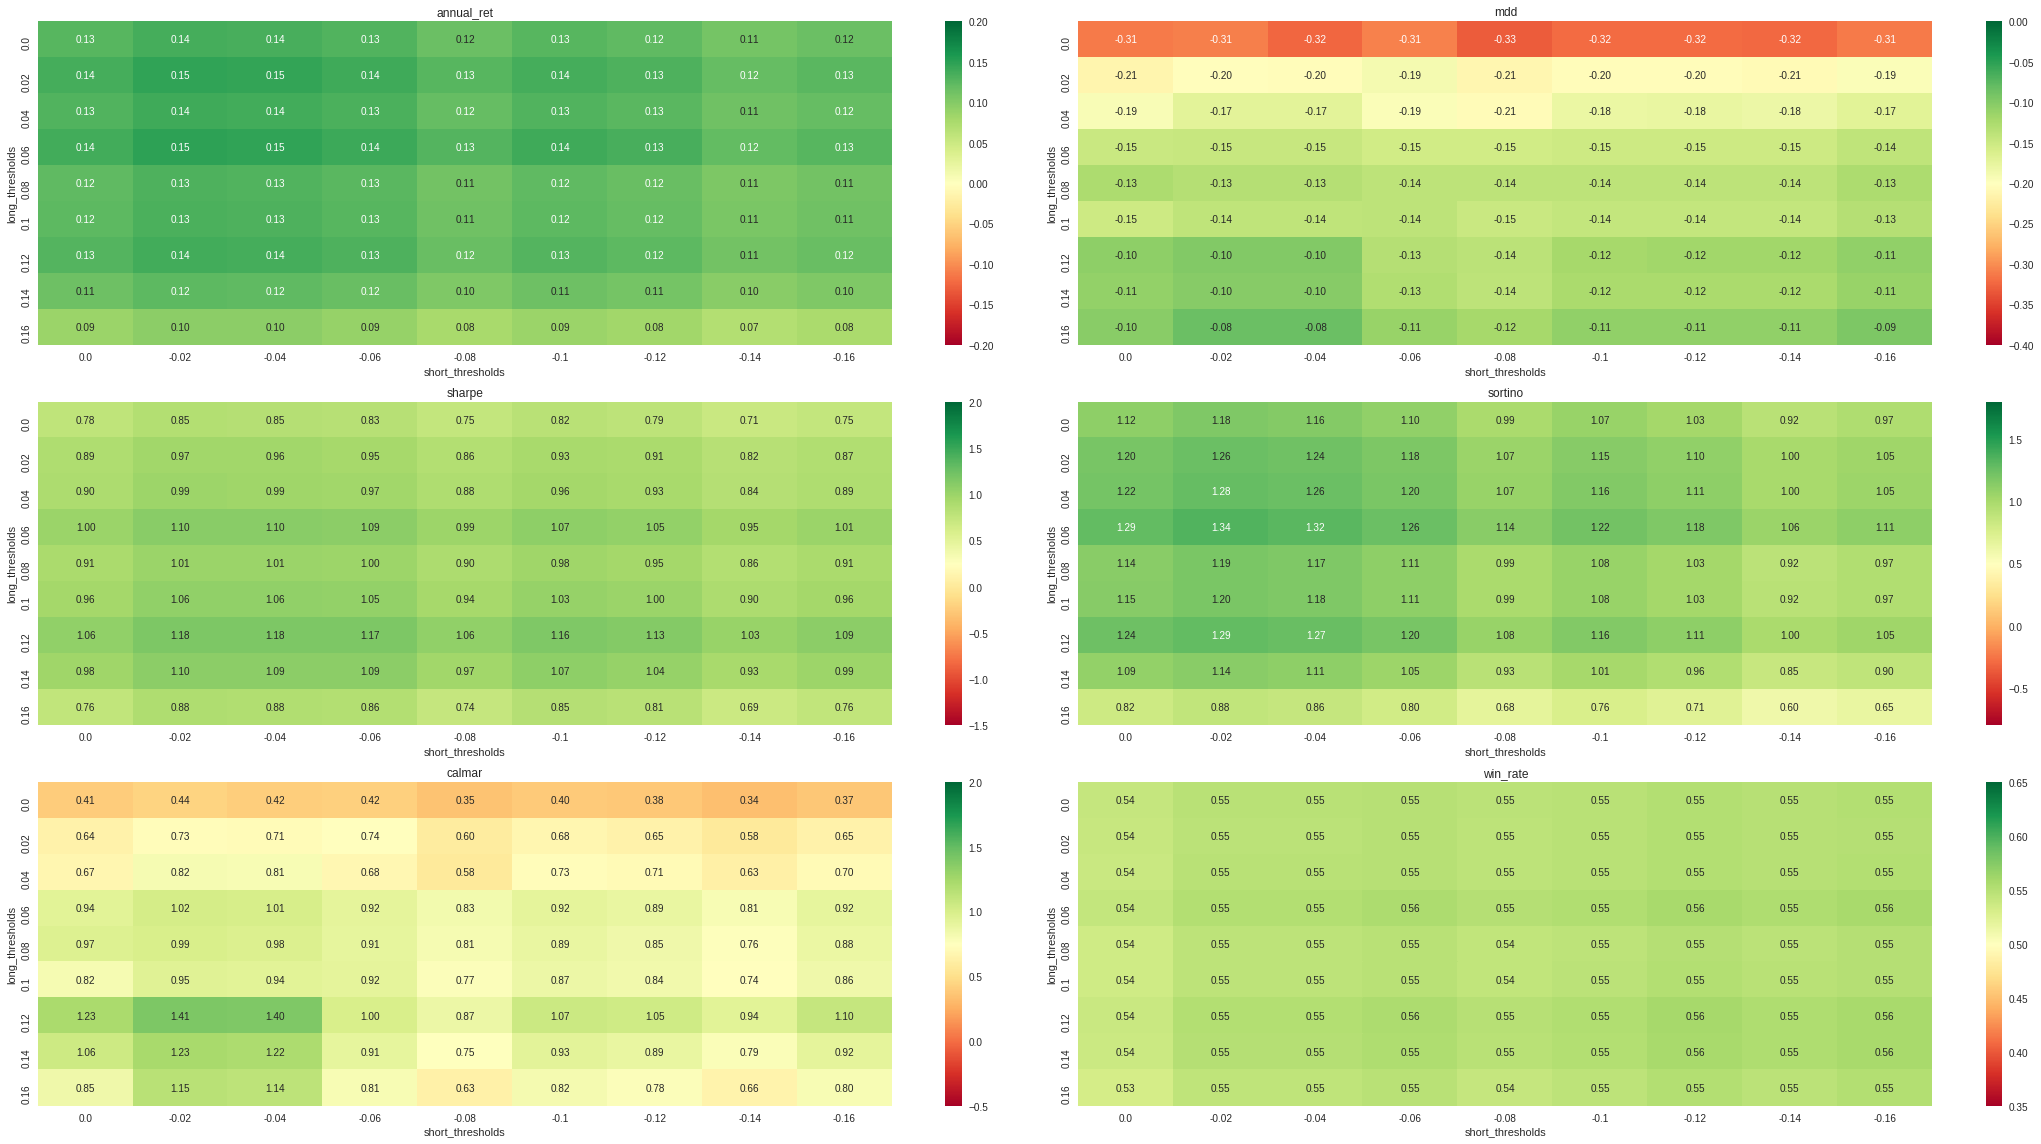

In [5]:
def strategy_1(df, long_threshold, short_threshold):
    _df = df.copy(deep=True)
    _df['signal'] = _df['score_content'].apply(lambda x: 1 if x>long_threshold else -1 if x<short_threshold else 0)
    return _df['signal'],_df['ret']

params_dict = {'long_thresholds': np.linspace(0,.16,9),
                'short_thresholds': np.linspace(0,-.16,9)}
strategy_heatmap(strategy_1, params_dict=params_dict ,metrics=['annual_ret','mdd', 'sharpe', 'sortino', 'calmar','win_rate'], save_name=None)

# Strategy 2

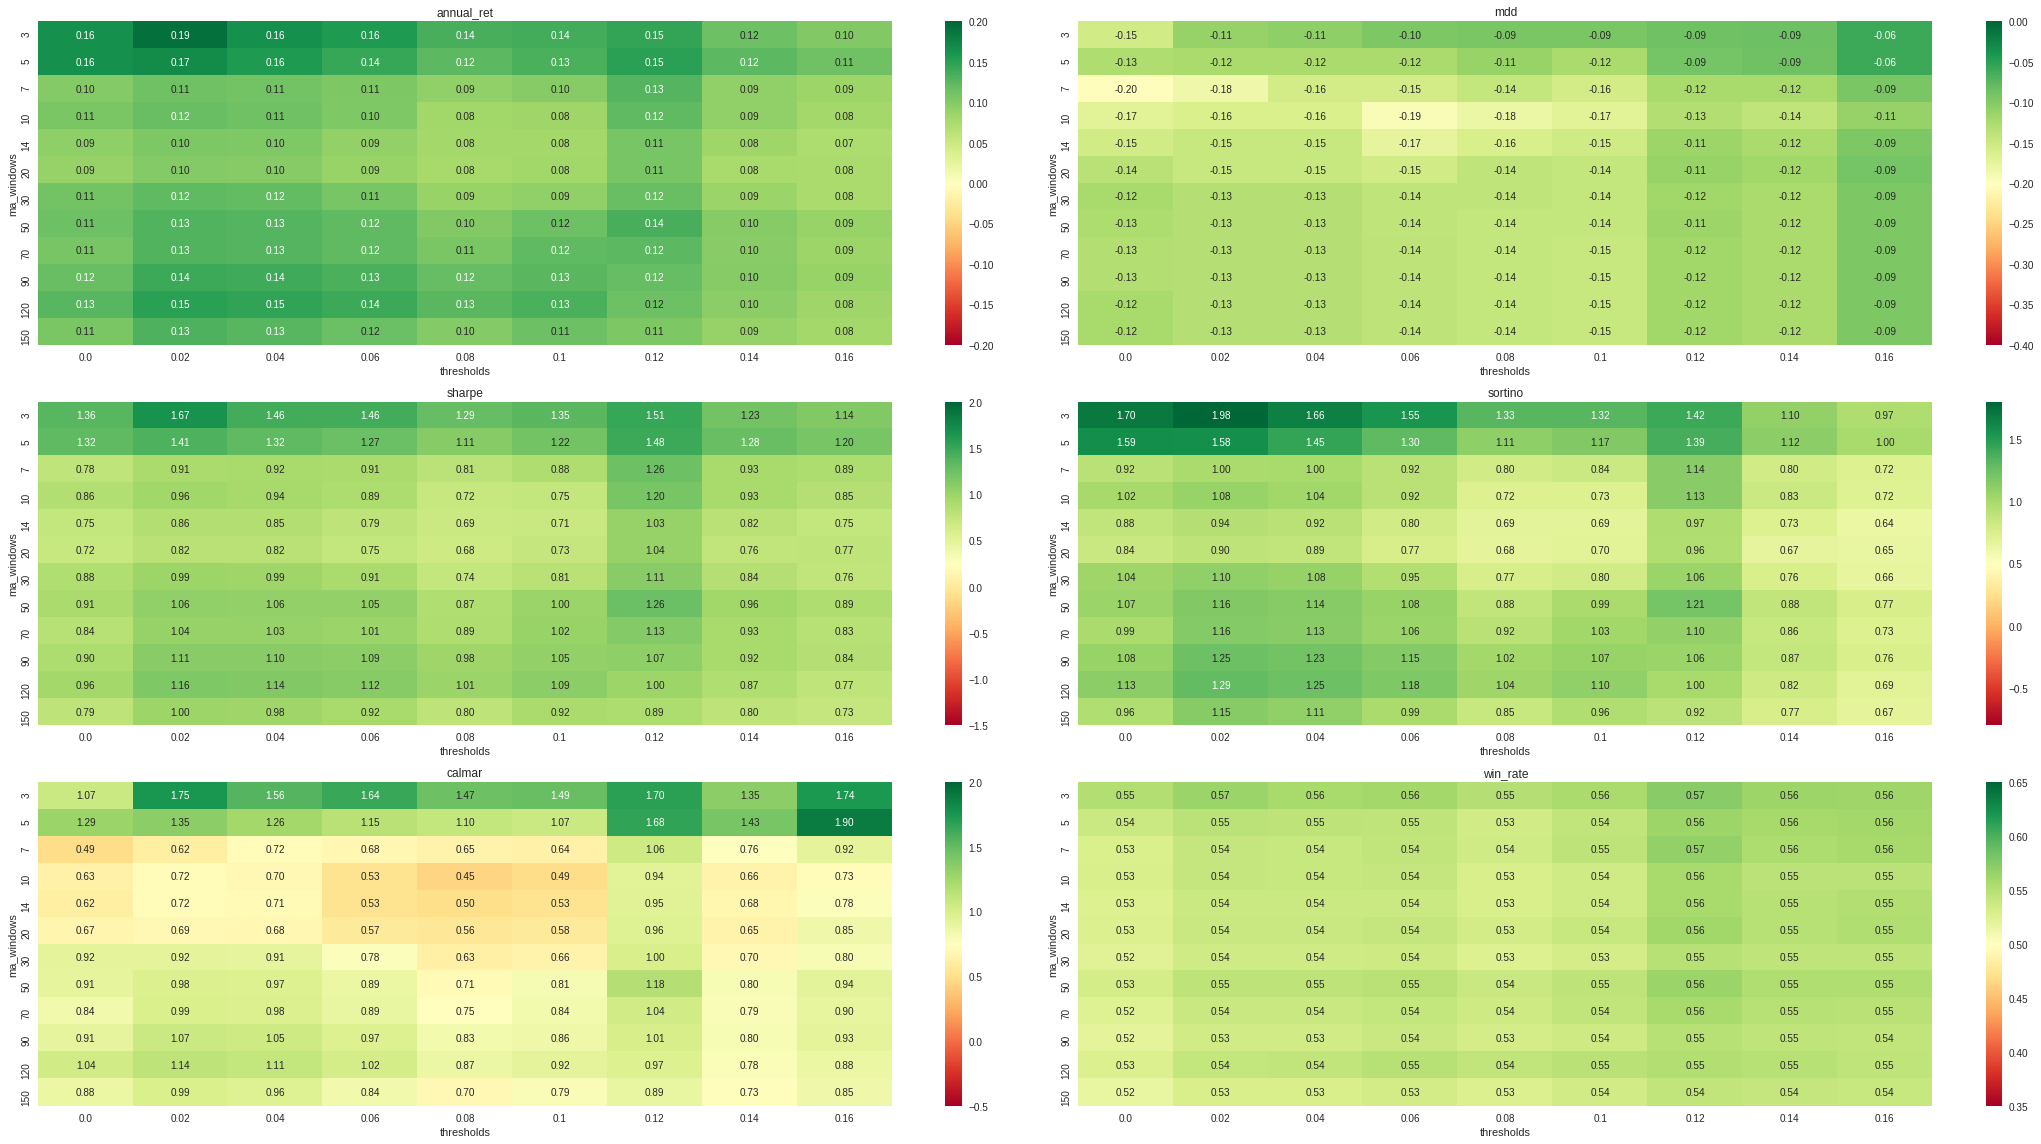

In [6]:
def strategy_2(df, ma_window, threshold):
    _df = df.copy(deep=True)
    _df['ma'] = _df['score_content'].rolling(window=ma_window).mean()
    _df.dropna(inplace=True)
    _df['signal'] = _df.apply(lambda x:1 if (x['score_content'] > x['ma'])& (x['score_content'] > threshold) else -1 if (x['score_content'] < x['ma'])& (x['score_content'] < -threshold) else 0, axis=1)
    return _df['signal'], _df['ret']

params_dict = {'ma_windows': [3,5,7,10,14,20,30,50,70, 90,120,150],
               'thresholds' :[0, 0.02, 0.04,0.06,0.08,0.1,0.12,0.14,0.16]}
strategy_heatmap(strategy_2, params_dict=params_dict ,metrics=['annual_ret','mdd', 'sharpe', 'sortino', 'calmar','win_rate'], save_name=None)

# Strategy 3

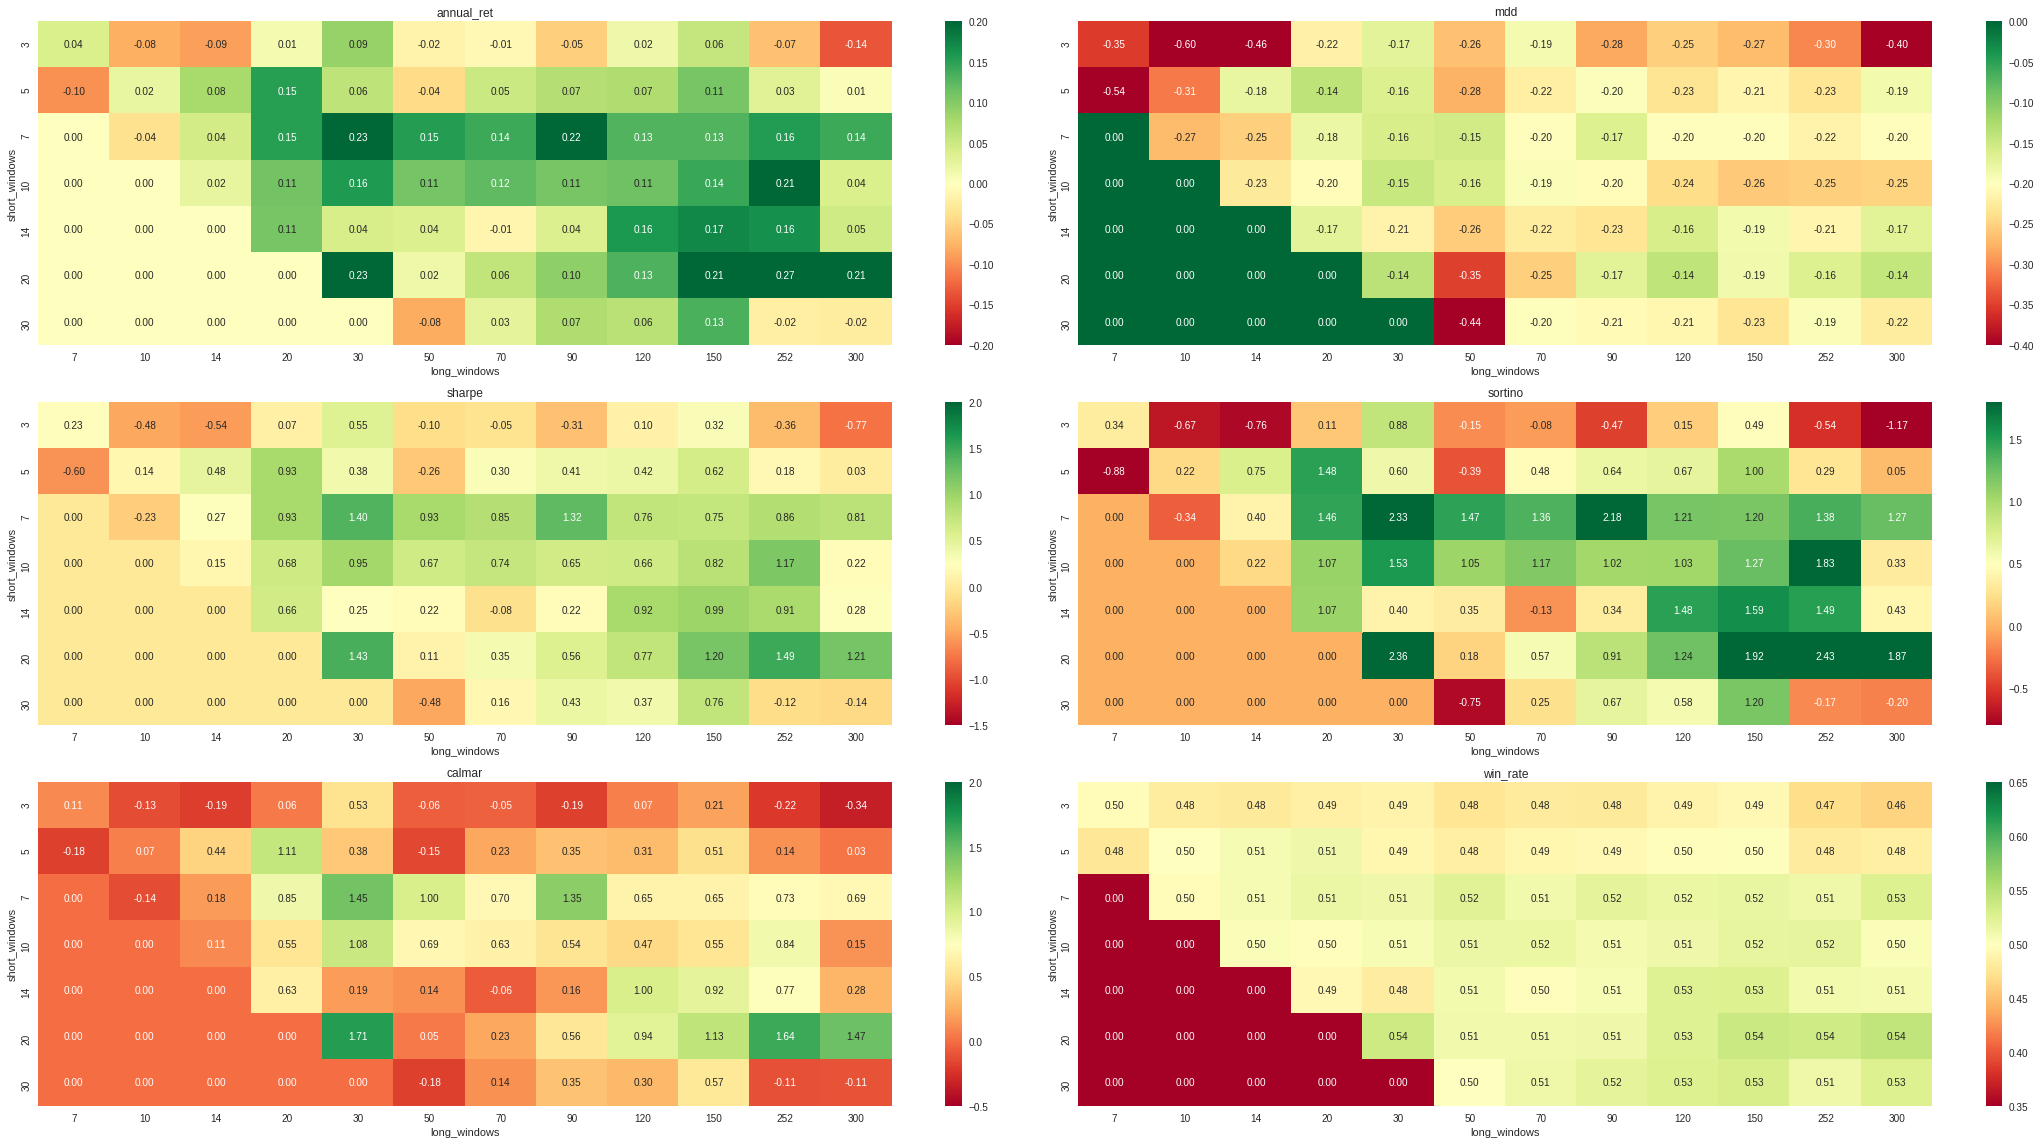

In [7]:
def strategy_3(df, short_window, long_window):
    _df = df.copy(deep=True)
    if short_window >= long_window:
        _df['signal'] = _df['ret'] * 0
        return _df['signal'], _df['ret']
    _df['long_ma'] = _df['score_content'].rolling(window=long_window).mean()
    _df['short_ma'] = _df['score_content'].rolling(window=short_window).mean()
    _df.dropna(inplace=True)
    _df['signal'] = _df.apply(lambda x:1 if x['short_ma']>x['long_ma'] else -1 if x['long_ma']>x['short_ma'] else 0, axis=1)
    return _df['signal'], _df['ret']

params_dict= {'short_windows'  : [3,5,7,10,14,20,30],
              'long_windows' :[7,10,14,20,30,50,70, 90,120,150,252,300]}
strategy_heatmap(strategy_3, params_dict=params_dict ,metrics=['annual_ret','mdd', 'sharpe', 'sortino', 'calmar','win_rate'], save_name=None)

# Strategy 4

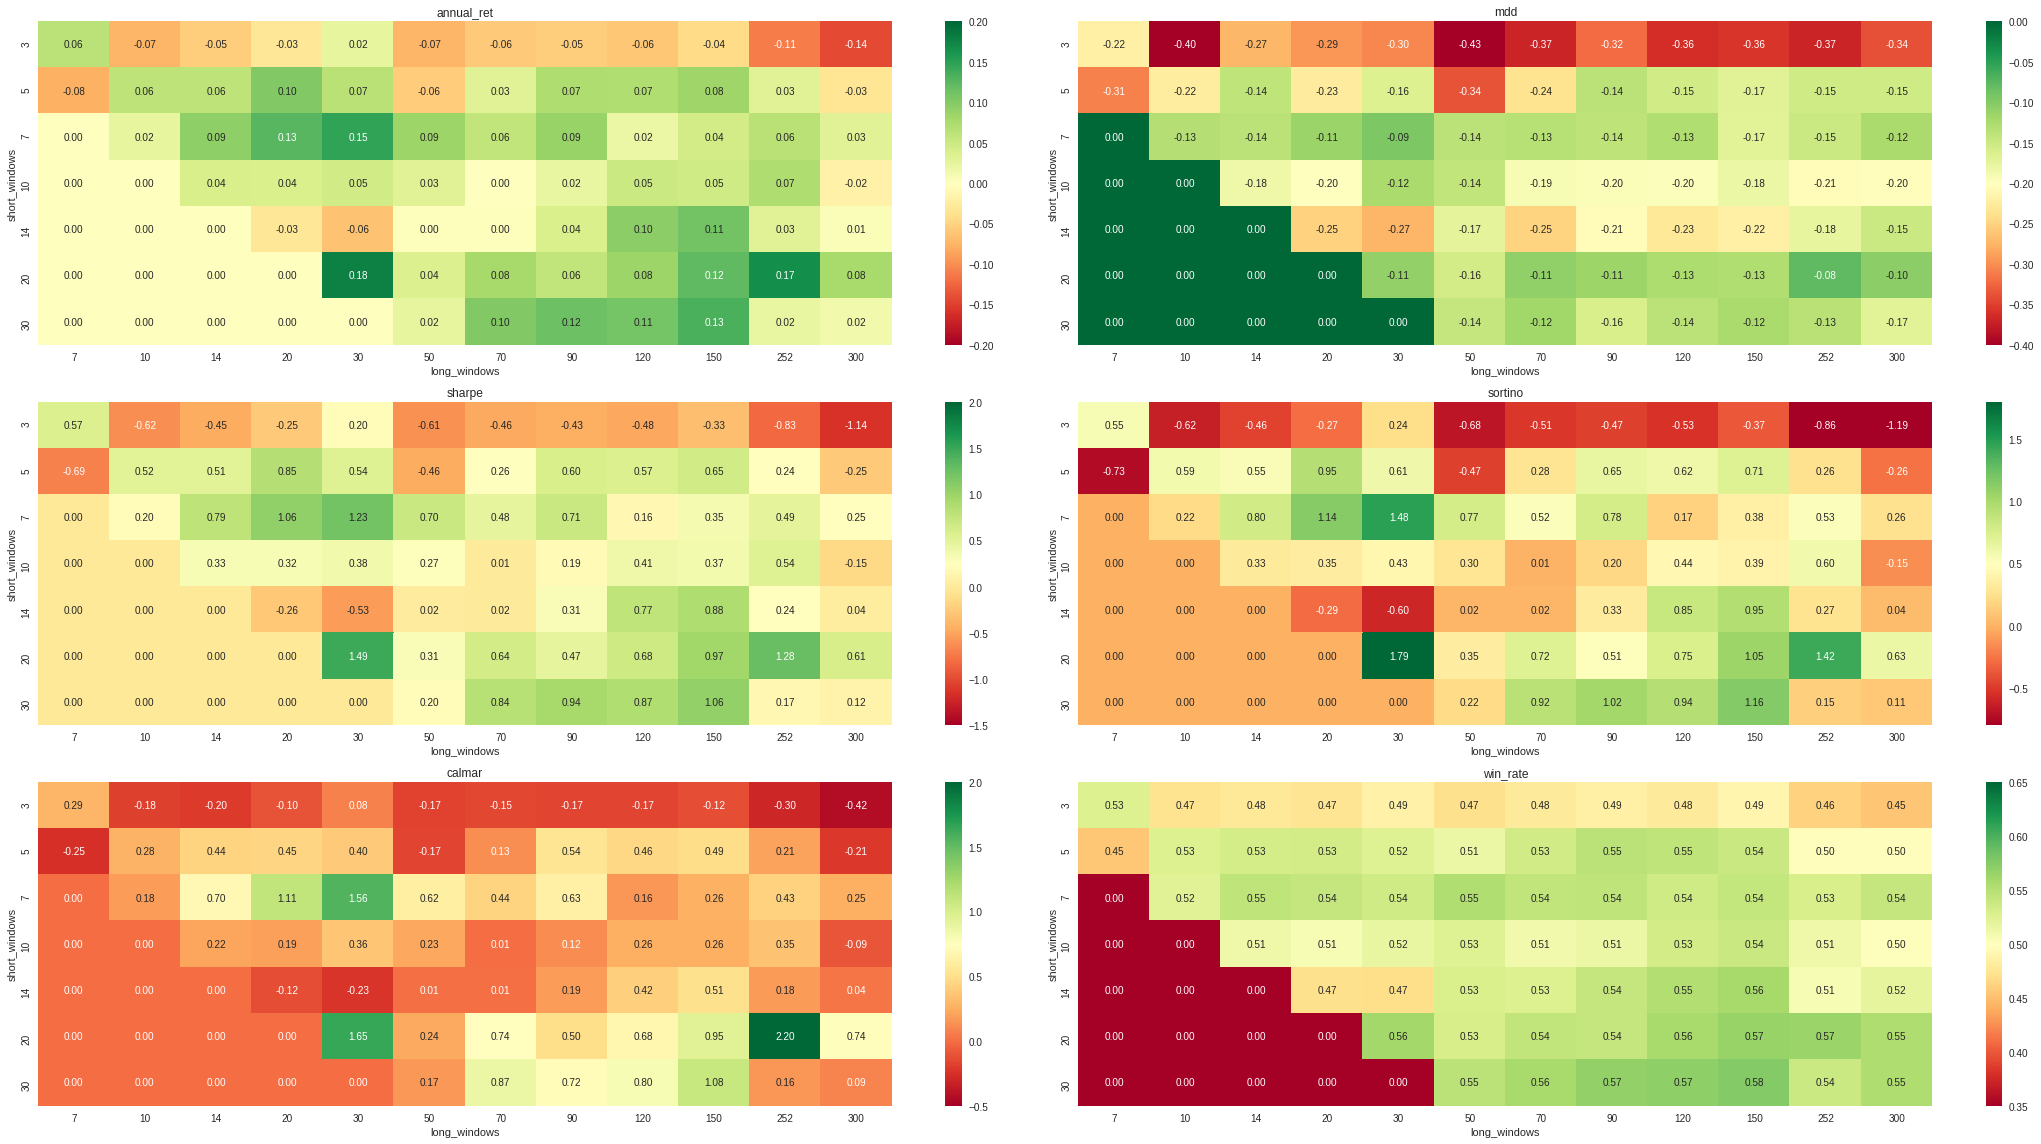

In [8]:
def strategy_4(df, short_window, long_window):
    _df = df.copy(deep=True)
    if short_window >= long_window:
        _df['signal'] = _df['ret'] * 0
        return _df['signal'], _df['ret']
    _df['long_ma'] = _df['score_content'].rolling(window=long_window).mean()
    _df['short_ma'] = _df['score_content'].rolling(window=short_window).mean()
    _df.dropna(inplace=True)
    _df['signal'] = _df.apply(lambda x:1 if x['short_ma']>x['long_ma'] else -1 if x['long_ma']>x['short_ma'] else 0, axis=1)
    for i in range(1, _df.shape[0]):
        if _df['signal'].iloc[i-1] != 0:
            _df['signal'].iloc[i] = 0
    return _df['signal'], _df['ret']

params_dict = {'short_windows' : [3,5,7,10,14,20,30],
'long_windows' : [7,10,14,20,30,50,70, 90,120,150,252,300]}
strategy_heatmap(strategy_4, params_dict=params_dict ,metrics=['annual_ret','mdd', 'sharpe', 'sortino', 'calmar','win_rate'], save_name=None)

# Plots

Text(0.5, 1.0, 'Strategy 1 | annual alpha = 0.125 | beta = 0.783')

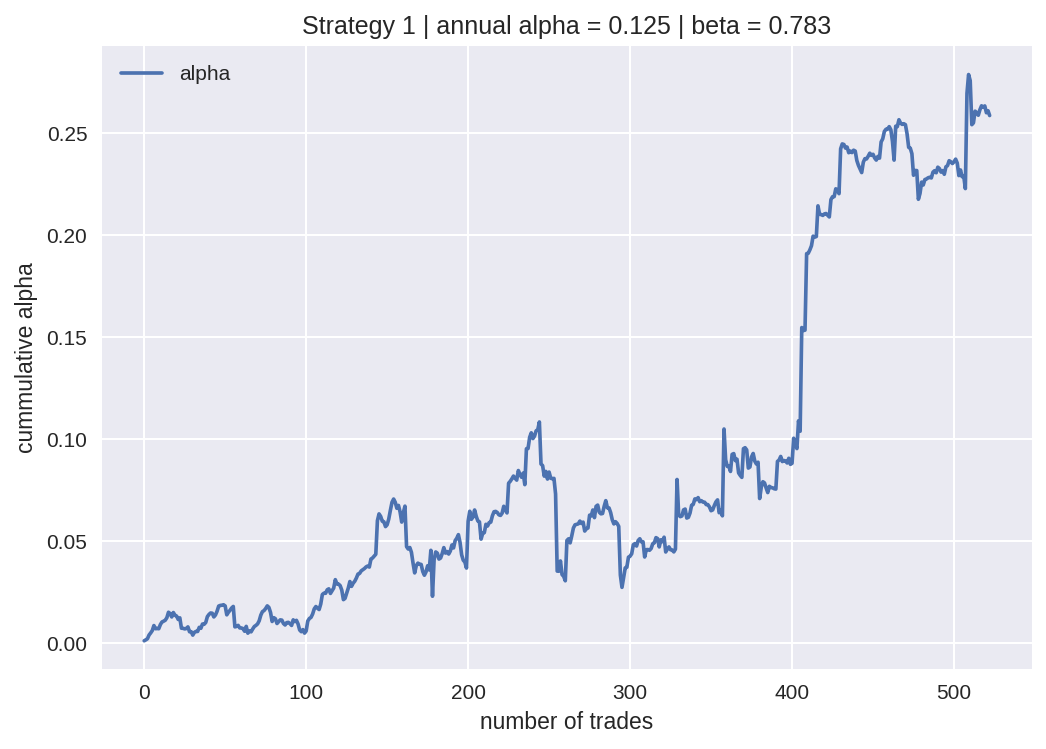

In [9]:
style.use('seaborn')
signal, ret = strategy_1(df,0.05,-0.05)
pnl = signal * ret
pnl = pnl[signal != 0].reset_index(drop=True)
ret = ret[signal != 0].reset_index(drop=True)
beta = np.cov(pnl, ret)[0,1]/ret.var()
alpha = pnl - beta*ret
#plt.hist(alpha, bins=30)
plt.figure(dpi=150)
m = (alpha.mean()*252)
(ret.mean()*252)
plt.plot(alpha.cumsum(), label='alpha')
plt.legend()
plt.xlabel('number of trades')
plt.ylabel('cummulative alpha')
plt.title(f'Strategy 1 | annual alpha = {"%.3g" %m} | beta = {"%.3g" %beta}')

Text(0.5, 1.0, 'Strategy 1 | annual alpha = 0.125 | beta = 0.783')

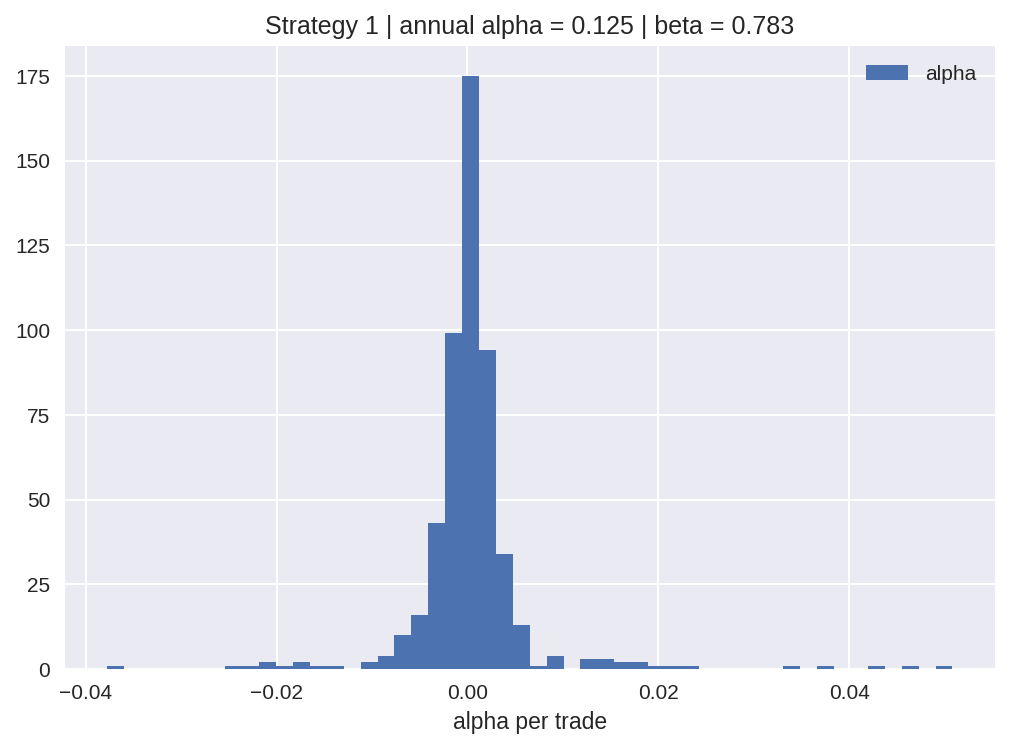

In [10]:
style.use('seaborn')
signal, ret = strategy_1(df,0.05,-0.05)
pnl = signal * ret
pnl = pnl[signal != 0].reset_index(drop=True)
ret = ret[signal != 0].reset_index(drop=True)
beta = np.cov(pnl, ret)[0,1]/ret.var()
alpha = pnl - beta*ret
#plt.hist(alpha, bins=30)
plt.figure(dpi=150)
m = (alpha.mean()*252)
(ret.mean()*252)
plt.hist(alpha, label='alpha', bins=50)
plt.legend()
plt.xlabel('alpha per trade')
plt.title(f'Strategy 1 | annual alpha = {"%.3g" %m} | beta = {"%.3g" %beta}')

Text(0.5, 1.0, 'Strategy 3 | annual alpha = 0.132 | beta = -0.0379')

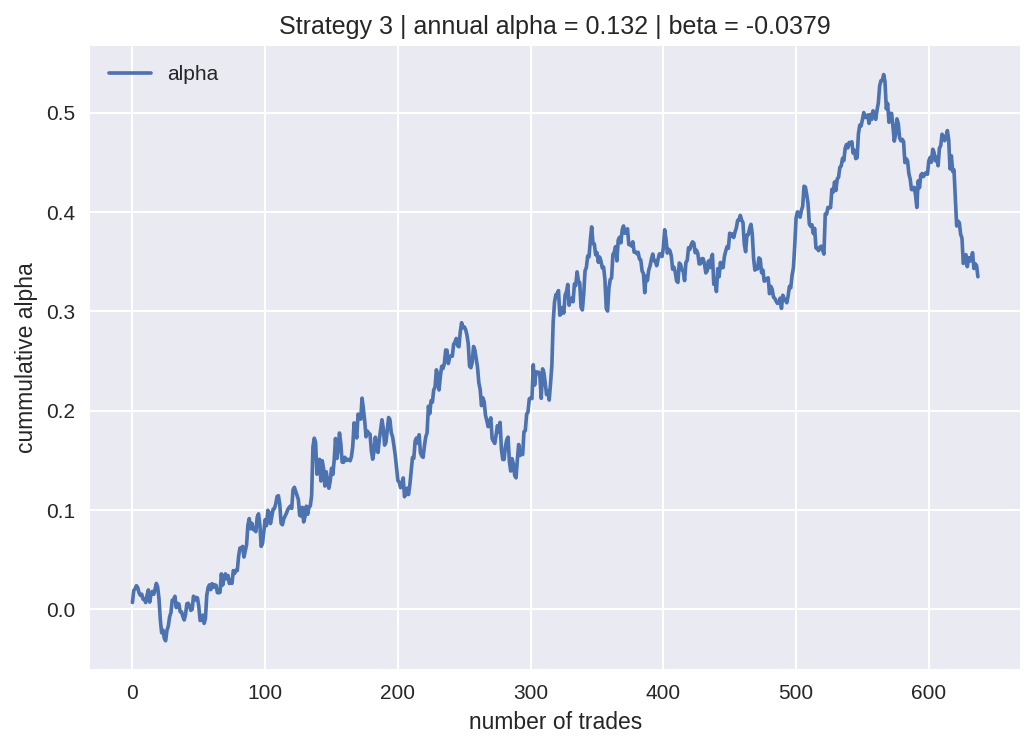

In [11]:
style.use('seaborn')
signal, ret = strategy_3(df,7,120)
pnl = signal * ret
pnl = pnl[signal != 0].reset_index(drop=True)
ret = ret[signal != 0].reset_index(drop=True)
beta = np.cov(pnl, ret)[0,1]/ret.var()
alpha = pnl - beta*ret
#plt.hist(alpha, bins=30)
plt.figure(dpi=150)
m = (alpha.mean()*252)
(ret.mean()*252)
plt.plot(alpha.cumsum(), label='alpha')
plt.legend()
plt.xlabel('number of trades')
plt.ylabel('cummulative alpha')
plt.title(f'Strategy 3 | annual alpha = {"%.3g" %m} | beta = {"%.3g" %beta}')

Text(0.5, 1.0, 'Strategy 3 | annual alpha = 0.132 | beta = -0.0379')

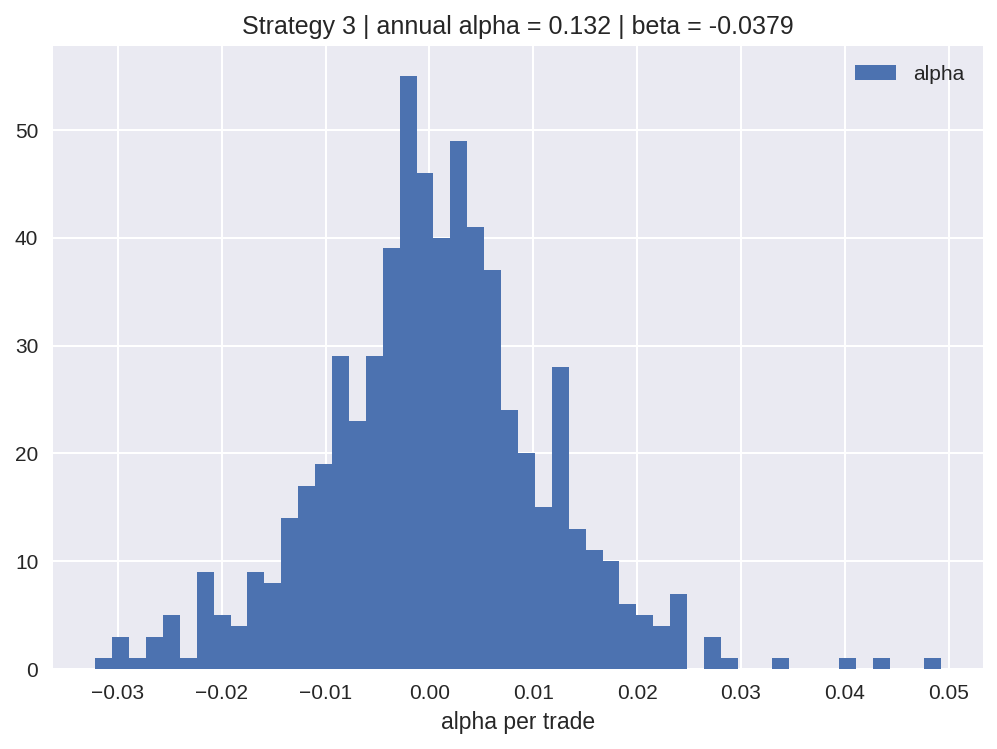

In [12]:
style.use('seaborn')
signal, ret = strategy_3(df,7,120)
pnl = signal * ret
pnl = pnl[signal != 0].reset_index(drop=True)
ret = ret[signal != 0].reset_index(drop=True)
beta = np.cov(pnl, ret)[0,1]/ret.var()
alpha = pnl - beta*ret
#plt.hist(alpha, bins=30)
plt.figure(dpi=150)
m = (alpha.mean()*252)
plt.hist(alpha, label='alpha', bins=50)
plt.legend()
plt.xlabel('alpha per trade')
plt.title(f'Strategy 3 | annual alpha = {"%.3g" %m} | beta = {"%.3g" %beta}')